In [1]:
import numpy as np
from numba import jit
import pints
import pints.plot
import pints_smol_jit_num_clus_pro as toy
import matplotlib.pyplot as plt



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0002, 0.0025, 500]


times = np.linspace(0, 97, 9700)

org_values = model.simulate(true_parameters, times)

print(org_values)

print(org_values.shape)


Init 1
[[5.00000000e+002 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [4.99500317e+002 2.62139880e-001 1.37561024e-004 ... 6.35986003e-319
  2.51973479e-322 0.00000000e+000]
 [4.99001370e+002 5.23506860e-001 5.49205579e-004 ... 2.89955856e-284
  3.04971525e-287 3.20351438e-290]
 ...
 [2.78359318e+000 2.84437375e+000 2.90570097e+000 ... 1.97133509e+001
  2.03015070e+001 2.09216123e+001]
 [2.77900802e+000 2.83988115e+000 2.90130497e+000 ... 1.97643931e+001
  2.03546617e+001 2.09769895e+001]
 [2.77442406e+000 2.83538944e+000 2.89690957e+000 ... 1.98155610e+001
  2.04079486e+001 2.10325060e+001]]
(9700, 100)


Perfect data

In [3]:
values = org_values
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 20000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     6      0         0         0          0:00.1
2     9      0         0         0          0:00.1


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_75443/3621038948.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_mcmc/_haario_bardenet_ac.py:89: UserWarning: The class `pints.AdaptiveCovarianceMCMC` is deprecated. Please use `pints.HaarioBardenetACMC` instead.
  warnings.warn(


3     12     0         0         0          0:01.3
20    63     0         0         0          0:06.1
40    123    0         0         0.0244     0:14.6
60    183    0.0164    0         0.0164     0:15.7
80    243    0.0123    0         0.0123     0:16.3
100   303    0.0198    0.0099    0.0099     0:18.8
120   363    0.0165    0.0165    0.0165     0:22.4
140   423    0.0142    0.0142    0.0142     0:23.3
160   483    0.0124    0.0124    0.0124     0:25.8
180   543    0.011     0.011     0.011      0:28.9
Initial phase completed.
200   603    0.00995   0.00995   0.00995    0:30.2
220   663    0.0136    0.0136    0.0226     0:31.3
240   723    0.0249    0.0332    0.0332     0:31.7
260   783    0.0268    0.0307    0.0613     0:32.0
280   843    0.032     0.0356    0.0747     0:32.4
300   903    0.0365    0.0399    0.0831     0:32.7
320   963    0.0343    0.0405    0.0997     0:33.1
340   1023   0.0352    0.044     0.103      0:33.5
360   1083   0.0471    0.0499    0.0997     0:33.9
380   

In [4]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


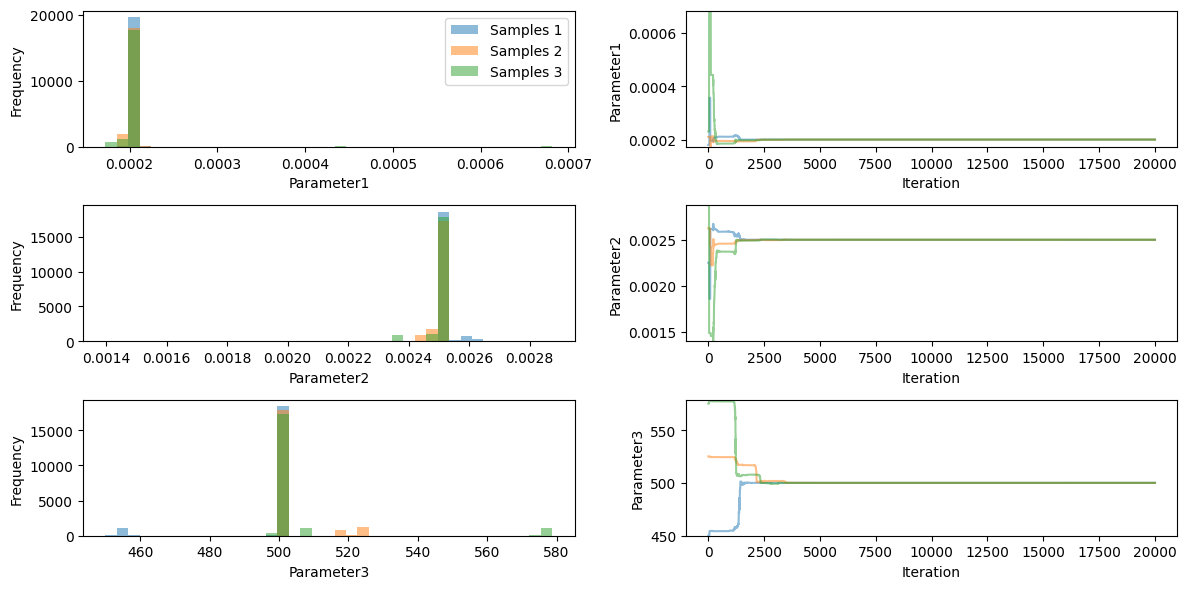

<class '__main__.MyMCMCSummary'>
param    mean    std.      2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  --------  ------  ------  ------  ------  -------  ------  -----  --------------
b        0.0002  1.29e-16  0.0002  0.0002  0.0002  0.0002  0.0002   1.01    68.7   0.192
p        0.0025  1.06e-15  0.0025  0.0025  0.0025  0.0025  0.0025   1       83.3   0.233
N        500     2.2e-11   500     500     500     500     500      1.03    71.3   0.2


In [5]:
pints.plot.trace(chains)
plt.savefig("perfect_data_full_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

Multiplicative noise

In [6]:
noise = 1
values = org_values *(1 + noise * np.random.normal(0, 1, org_values.shape))
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 20000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.1


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_75443/3370784914.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_mcmc/_haario_bardenet_ac.py:89: UserWarning: The class `pints.AdaptiveCovarianceMCMC` is deprecated. Please use `pints.HaarioBardenetACMC` instead.
  warnings.warn(


3     12     0         0         0          0:00.4
20    63     0.0476    0         0.0476     0:01.5
40    123    0.0244    0         0.0244     0:03.5
60    183    0.0164    0         0.0164     0:04.3
80    243    0.0123    0         0.0123     0:05.5
100   303    0.0099    0         0.0099     0:06.4
120   363    0.00826   0.00826   0.00826    0:08.0
140   423    0.00709   0.00709   0.00709    0:09.6
160   483    0.00621   0.00621   0.00621    0:10.9
180   543    0.011     0.00552   0.00552    0:11.7
Initial phase completed.
200   603    0.0149    0.00995   0.00498    0:12.7
220   663    0.0136    0.0181    0.0226     0:13.6
240   723    0.0207    0.0415    0.0373     0:13.9
260   783    0.0268    0.069     0.0651     0:14.2
280   843    0.0498    0.0676    0.0676     0:14.5
300   903    0.0565    0.0731    0.0797     0:14.8
320   963    0.0841    0.0748    0.0966     0:15.1
340   1023   0.106     0.0733    0.0997     0:15.4
360   1083   0.108     0.0693    0.102      0:15.7
380   

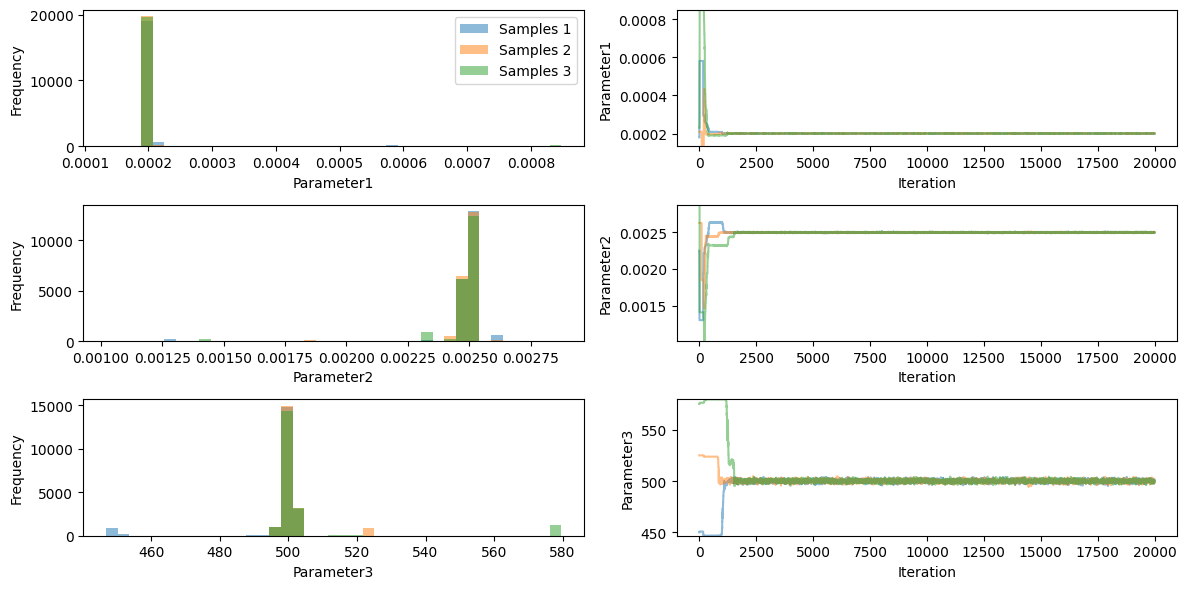

<class '__main__.MyMCMCSummary'>
param    mean    std.      2.5%     25%      50%     75%       97.5%     rhat    ess       ess per sec.
-------  ------  --------  -------  -------  ------  --------  --------  ------  --------  --------------
b        0.0002  3.37e-07  0.0002   0.0002   0.0002  0.000201  0.000201  1       2.22e+03  6.47
p        0.0025  3.85e-06  0.00249  0.00249  0.0025  0.0025    0.0025    1       2.53e+03  7.38
N        500     1.31      497      499      500     501       503       1       2.49e+03  7.26


In [7]:
pints.plot.trace(chains)
plt.savefig("noisy_data_multiplicative_full_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

Additive noise

In [8]:
noise = 1
values = org_values + noise * np.random.normal(0, 0.25, org_values.shape)
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 20000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0.333      0:00.1
3     12     0         0         0.25       0:00.1


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_75443/2606738043.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


20    63     0         0         0.0952     0:02.8
40    123    0         0         0.0488     0:03.7
60    183    0         0.0164    0.0328     0:05.5
80    243    0         0.0123    0.0247     0:07.2
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.8894439024899D+02   r2 =  0.3332392966475D-11


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


100   303    0         0.0099    0.0297     0:11.4
120   363    0         0.00826   0.0248     0:13.4
140   423    0         0.00709   0.0213     0:14.2
160   483    0.00621   0.0124    0.0186     0:15.1
180   543    0.00552   0.0166    0.0166     0:18.4
Initial phase completed.
200   603    0.00498   0.0149    0.0149     0:20.4
220   663    0.0136    0.0226    0.0317     0:21.5
240   723    0.0166    0.0249    0.0373     0:21.8
260   783    0.0268    0.0383    0.0575     0:22.1
280   843    0.0356    0.0463    0.0712     0:22.4
300   903    0.0399    0.0698    0.0831     0:22.8
320   963    0.0436    0.0872    0.0935     0:23.1
340   1023   0.044     0.109     0.0938     0:23.5
360   1083   0.0499    0.111     0.097      0:23.8
380   1143   0.0525    0.11      0.108      0:24.1
400   1203   0.0623    0.107     0.105      0:24.4
420   1263   0.0713    0.105     0.0998     0:24.7
440   1323   0.0794    0.104     0.0952     0:25.0
460   1383   0.0998    0.102     0.0911     0:25.3
480   

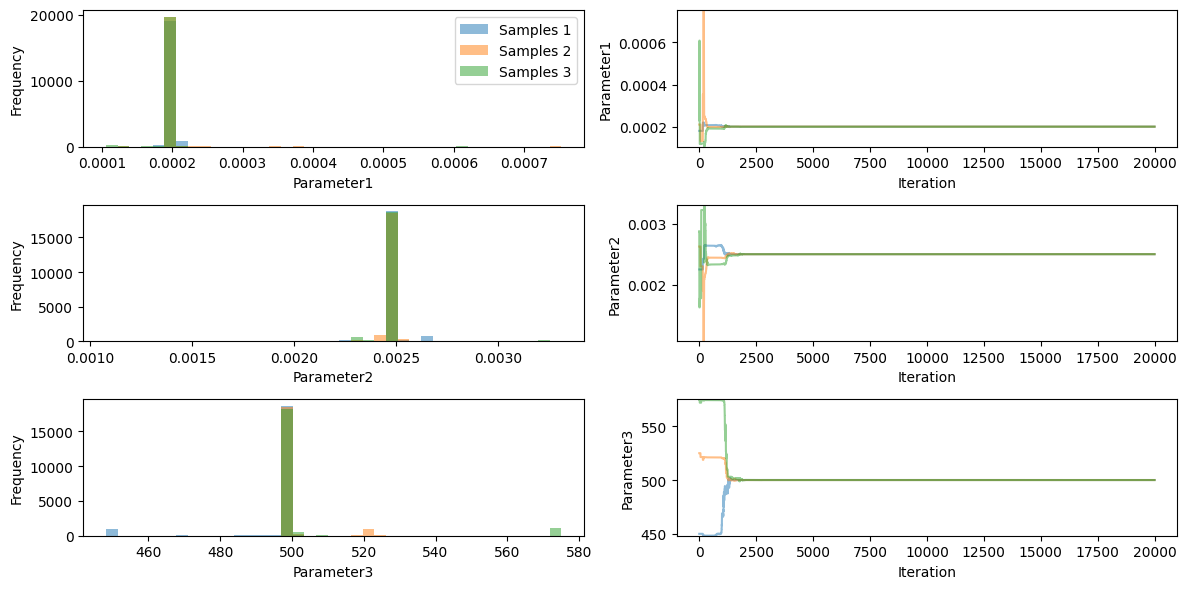

<class '__main__.MyMCMCSummary'>
param    mean    std.      2.5%    25%     50%     75%     97.5%    rhat    ess       ess per sec.
-------  ------  --------  ------  ------  ------  ------  -------  ------  --------  --------------
b        0.0002  5.78e-09  0.0002  0.0002  0.0002  0.0002  0.0002   1       2.29e+03  6.33
p        0.0025  8.27e-08  0.0025  0.0025  0.0025  0.0025  0.0025   1       2.26e+03  6.24
N        500     0.0142    500     500     500     500     500      1       2.4e+03   6.63


In [9]:
pints.plot.trace(chains)
plt.savefig("noisy_data_additive_full_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)